# Deep Vision Project by Fabian Schmidt
####  Who is allowed to enter the classroom: Contrastive Learning for face and signature recognition

<a id="0"></a>
 # Table of Contents
1. [Preparing the Dataset](#1)     
    a. [Download Datasets](#1a)


## Preparing the Dataset<a class="anchor" id="1"></a>

#### Download UTKFace and signature-verification Dataset<a class="anchor" id="1a">

In [6]:
import opendatasets as od 
import pandas 

!wget https://hydranets-data.s3.eu-west-3.amazonaws.com/UTKFace.zip
!unzip UTKFace.zip -d data && rm UTKFace.zip
!rm -rf __MACOSX/
!rm -rf data/__MACOSX

  
od.download("https://www.kaggle.com/datasets/mallapraveen/signature-matching/data") 

!mv signature-matching/custom data
!rmdir signature-matching/
!mv data/custom data/signature

[Back to the top](#0) 

In [69]:
import glob
import random 

random.seed(42)
signatures_paths = glob.glob("data/signature/full/[0-9][0-9][0-9]/*_00.png") # ugly...I know but glob doesnt support [0-9]{3}
face_paths = random.sample(glob.glob("data/UTKFace/2[0-9]*.jpg"), len(signatures_paths))
face_signature = list(zip(face_paths, signatures_paths))

In [70]:
face_signature[0]

('data/UTKFace/26_0_0_20170120134255183.jpg.chip.jpg',
 'data/signature/full/088/088_00.png')

In [71]:
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import glob
import os

class UTKFaceSignature(Dataset):
    def __init__(self, face_signature_path):

        # Mean and Std for ImageNet
        mean=[0.485, 0.456, 0.406] # ImageNet
        std=[0.229, 0.224, 0.225] # ImageNet

        # Define the Transforms
        self.transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor(), transforms.Normalize(mean, std)])

        self.face_signature_path = face_signature_path


    def __len__(self):
        return len(self.face_signature_path)
    
    def __getitem__(self, index):
        face_img = Image.open(self.face_signature_path[index][0]).convert('RGB')
        signature_img = Image.open(self.face_signature_path[index][1]).convert('RGB')
        
        face_img = self.transform(face_img)
        signature_img = self.transform(signature_img)

        sample= {'Face': face_img, 'Signature': signature_img}
        return sample

In [72]:
import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader

# define the train and val splits
TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.3

# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_train = round(TRAIN_SPLIT*len(face_paths))
num_val = round(VAL_SPLIT*len(face_paths))

print('No of train samples', num_train)
print('No of validation Samples', num_val)

(train_dataset, valid_dataset) = random_split(face_signature,[num_train, num_val],generator=torch.Generator().manual_seed(42))


No of train samples 83
No of validation Samples 36


In [73]:
BATCH_SIZE = 64

train_dataloader = DataLoader(UTKFaceSignature(train_dataset), shuffle=True, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(UTKFaceSignature(valid_dataset), shuffle=False, batch_size=BATCH_SIZE)

train_steps = len(train_dataloader.dataset) // BATCH_SIZE
val_steps = len(val_dataloader.dataset) // BATCH_SIZE

In [120]:
def print_sample(sample):
    iterator = iter(sample)
    fig, axs = plt.subplots(1,2)

    for i, key in enumerate(iterator):
        #Get Tensor to right shape
        image_tensor = sample[key][0]  
        image_numpy = image_tensor.permute(1, 2, 0).numpy()

        # Normalize
        image_numpy = (image_numpy - image_numpy.min()) / (image_numpy.max() - image_numpy.min())
        print(key)
        axs[i].imshow(image_numpy)
        axs[i].axis('off')
        axs[i].set_title(key)
    
    plt.show()


Face
Signature


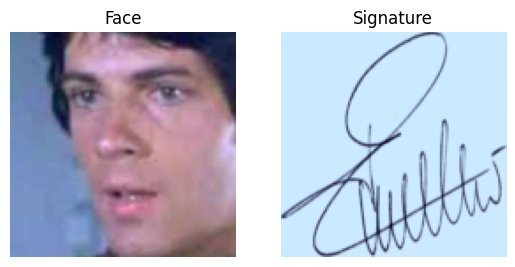

In [121]:
sample = next(iter(train_dataloader))

print_sample(sample)

